## Dedicated to various Lidar differencing

In [1]:
import os
from osgeo import gdal
import rioxarray
import rasterio
import pygmt
import sys
sys.path.append('/Users/chanagan/Documents/GitHub/ImageryResources/Functions/')
import TiffTools as tt
#gdal.AllRegister()

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2


In [3]:
# low res Stitch together lidar tiles
rewrite = False
year = 2004
area = 1

if year == 2018:
    if area == 1:
        folder = '/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/Area1_2018_FEMA_dem/Area1_2018_FEMA_dem_export/'
    if area == 2:
        folder = '/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/Area2_2018_FEMA_dem/Area2_2018_FEMA_dem_export/'
    if area == 3:
        folder = '/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/Area3_2018_Parkfield_dem/Area3_2018_Parkfield_dem_export/'
elif year == 2004:
    if area == 1:
        folder = '/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/Area1_2007_GES_dem/Area1_2007_GES_dem_export/'
    if area == 2:
        folder = '/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/Area2_2004_B4_dem/Area2_2004_B4_dem_export/'
    if area == 3:
        folder = '/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/Area3_2004_B4_dem/Area3_2004_B4_dem_export/'
#ullr = [714171-1000,3987665+1000, 753035-1000,3956721+1000]
#ullr = [675564-2000, 4035914-2000, 675564+2000, 4035914+2000]
ullr = None
flist = []

for file in os.listdir(folder):
    if file.endswith('tif') and file[0] != '.':
        if ullr != None:
            x, y = int(file[1:7]), int(file[8:15])
            if x >= ullr[0] and y <= ullr[1] and x <= ullr[2] and y >= ullr[3]:
                flist.append(folder+file)
        else:
            flist.append(folder+file)

if rewrite == True:
    with gdal.Warp(
    #f'/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/{year}_dem_MRMR_mosaic_202412.tif',
    f'/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/2mMosaics/{folder.split('/')[-2]}.tif',
    flist,
    srcSRS='EPSG:26910',
    dstSRS='EPSG:32610',
    srcNodata=3.4e+38,
    dstNodata=-9999,
    format='GTiff',
    xRes=2,
    yRes=2  
    ) as im:
        im.FlushCache()


In [3]:
flist = ['/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/Area1_2018_FEMA_dem/Area1_2018_FEMA_dem_export/',
            '/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/Area2_2018_FEMA_dem/Area2_2018_FEMA_dem_export/',
            '/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/Area3_2018_Parkfield_dem/Area3_2018_Parkfield_dem_export/']
flist_post = []
for folder in flist:
    for file in os.listdir(folder):
        if file.endswith('tif') and file[0] != '.':
            flist_post.append(folder+file)

flist = ['/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/Area1_2007_GES_dem/Area1_2007_GES_dem_export/',
        '/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/Area2_2004_B4_dem/Area2_2004_B4_dem_export/',
        '/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/Area3_2004_B4_dem/Area3_2004_B4_dem_export/']
flist_pre = []
for folder in flist:
    for file in os.listdir(folder):
        if file.endswith('tif') and file[0] != '.':
            flist_pre.append(folder+file)

In [4]:
flist_pre

['/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/Area1_2007_GES_dem/Area1_2007_GES_dem_export/T678000_4031000_2007_be.tif',
 '/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/Area1_2007_GES_dem/Area1_2007_GES_dem_export/T658000_4060000_2007_be.tif',
 '/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/Area1_2007_GES_dem/Area1_2007_GES_dem_export/T624000_4083000_2007_be.tif',
 '/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/Area1_2007_GES_dem/Area1_2007_GES_dem_export/T694000_4016000_2007_be.tif',
 '/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/Area1_2007_GES_dem/Area1_2007_GES_dem_export/T690000_4018000_2007_be.tif',
 '/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/Area1_2007_GES_dem/Area1_2007_GES_dem_export/T650000_4063000_2007_be.tif',
 '/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/Area1_2007_GES_dem/Area1_2007_GES_dem_export/T677000_4035000_2007_be.tif',
 '/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/Area1_2007_GES_dem/Area1_2007_GES_dem_export/T672000_4040000_2007_be.tif',
 '/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/Area1_2007_GES_dem/Are

In [ ]:
cutlinesf = '/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/GIS/FinalCutlines/'
filepref = ['one','two','three','four','five','six','seven','eight','nine']

rewrite = False

for pref in ['four']:#filepref:
    cutline = cutlinesf+pref+'.shp'

    if rewrite == True:
        with gdal.Warp(
        f'/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/SubareaMosaics50cm/Pre-Area-{pref}.tif',
        flist_pre,
        srcSRS='EPSG:26910',
        dstSRS='EPSG:32610',
        cutlineDSName=cutline,
        cropToCutline=True,
        srcNodata=3.4e+38,
        dstNodata=-9999,
        format='GTiff',
        xRes=0.5,
        yRes=0.5  
        ) as im:
            im.FlushCache()

        with gdal.Warp(
        f'/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/SubareaMosaics50cm/Post-Area-{pref}.tif',
        flist_post,
        srcSRS='EPSG:26910',
        dstSRS='EPSG:32610',
        cutlineDSName=cutline,
        cropToCutline=True,
        srcNodata=3.4e+38,
        dstNodata=-9999,
        format='GTiff',
        xRes=0.5,
        yRes=0.5  
        ) as im:
            im.FlushCache()
    

## Correlation

In [1]:
import os
from osgeo import gdal
import sys
sys.path.append('/Users/chanagan/Documents/GitHub/ImageryResources/Functions/')
import TiffTools as tt 
#gdal.AllRegister()

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

In [ ]:
#!/bin/bash
mm3d Mm2dPosSism Pre-Area-one.tif Post-Area-one.tif CorMin=0.1 Dequant=false DirMEC='MEC_Area1/' #SsResolOpt=1
mm3d Mm2dPosSism Pre-Area-two.tif Post-Area-two.tif CorMin=0.1 Dequant=false DirMEC='MEC_Area2/' #SsResolOpt=1
mm3d Mm2dPosSism Pre-Area-three.tif Post-Area-three.tif CorMin=0.1 Dequant=false DirMEC='MEC_Area3/'#SsResolOpt=1 
mm3d Mm2dPosSism Pre-Area-four.tif Post-Area-four.tif CorMin=0.1 Dequant=false DirMEC='MEC_Area4/' #SsResolOpt=1
mm3d Mm2dPosSism Pre-Area-five.tif Post-Area-five.tif CorMin=0.1 Dequant=false DirMEC='MEC_Area5/' #SsResolOpt=1
mm3d Mm2dPosSism Pre-Area-six.tif Post-Area-six.tif CorMin=0.1 Dequant=false DirMEC='MEC_Area6/' #SsResolOpt=1
mm3d Mm2dPosSism Pre-Area-seven.tif Post-Area-seven.tif CorMin=0.1 Dequant=false DirMEC='MEC_Area7/'#SsResolOpt=1
mm3d Mm2dPosSism Pre-Area-eight.tif Post-Area-eight.tif CorMin=0.1 Dequant=false DirMEC='MEC_Area8/' #SsResolOpt=1
mm3d Mm2dPosSism Pre-Area-nine.tif Post-Area-nine.tif CorMin=0.1 Dequant=false DirMEC='MEC_Area9/' #SsResolOpt=1 


'Area1_2018_FEMA_dem_export'

In [2]:
# stitch together output
arean, areas = '4','four'
for dir in ['Px1','Px2']:
    im1 = gdal.Open(f'/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/MicmacAreaResults/MEC_Area{arean}/{dir}_Num5_DeZoom1_LeChantier_Tile_0_0.tif') 
    im1data = im1.GetRasterBand(1).ReadAsArray()
    im2 = gdal.Open(f'/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/MicmacAreaResults/MEC_Area{arean}/{dir}_Num5_DeZoom1_LeChantier_Tile_1_0.tif') 
    im2data = im2.GetRasterBand(1).ReadAsArray()
    im3 = gdal.Open(f'/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/MicmacAreaResults/MEC_Area{arean}/{dir}_Num5_DeZoom1_LeChantier_Tile_0_1.tif') 
    im3data = im3.GetRasterBand(1).ReadAsArray()
    im4 = gdal.Open(f'/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/MicmacAreaResults/MEC_Area{arean}/{dir}_Num5_DeZoom1_LeChantier_Tile_1_1.tif')
    im4data = im4.GetRasterBand(1).ReadAsArray()
    stack = np.concat([np.hstack([im1data,im2data]), np.hstack([im3data,im4data])])
    tt.save_geotiff(stack,f'/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/MicmacAreaResults/MEC_Area{arean}/{dir}_Num5_DeZoom1_LeChantier.tif',im1.GetGeoTransform(),'')

tt.micmacPostProcessing(folder=f'/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/MicmacAreaResults/MEC_Area{arean}/',
                         prefiles=[f'/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/SubareaMosaics50cm/Post-Area-{areas}.tif',
                                   f'/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/SubareaMosaics50cm/Pre-Area-{areas}.tif'],#predem
                         outprefix=f'/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/MicmacAreaResults/MEC_Area{arean}/')

#par, perp = tt.projectDisp(f'/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/MicmacAreaResults/MEC_Area{arean}/EWmicmac.tif',
#                           f'/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/MicmacAreaResults/MEC_Area{arean}/NSmicmac.tif',
#                           -45,
#                           partif=f'/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/MicmacAreaResults/MEC_Area{arean}/ParallelDisp.tif',
#                           perptif=f'/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/MicmacAreaResults/MEC_Area{arean}/PerpendicularDisp.tif')
#


/Users/chanagan/miniforge3/envs/image_processing/lib/python3.13/site-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Nodata value for mask: -9999.0
Setting nodata value to -9999
Saving /Volumes/ProjectsGarlockCSAF/CSAF_Lidar/MicmacAreaResults/MEC_Area4/NSmicmac.tif
Saving /Volumes/ProjectsGarlockCSAF/CSAF_Lidar/MicmacAreaResults/MEC_Area4/EWmicmac.tif
Saving /Volumes/ProjectsGarlockCSAF/CSAF_Lidar/MicmacAreaResults/MEC_Area4/Correlmicmac.tif


In [3]:
filepref = [1]# Done [1,2,3,4]

for arean in filepref:
    im1 = gdal.Open(f'/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/MicmacAreaResults/MEC_Area{arean}/EWmicmac.tif')
    band = -1*im1.GetRasterBand(1).ReadAsArray()
    band[band == 9999] = -9999
    tt.save_geotiff(band,f'/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/MicmacAreaResults/MEC_Area{arean}/EWmicmac.tif', im1.GetGeoTransform(), im1.GetProjection(),nodata=-9999)
    im2 = gdal.Open(f'/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/MicmacAreaResults/MEC_Area{arean}/NSmicmac.tif')
    band = -1*im2.GetRasterBand(1).ReadAsArray()
    band[band == 9999] = -9999
    tt.save_geotiff(band,f'/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/MicmacAreaResults/MEC_Area{arean}/NSmicmac.tif', im2.GetGeoTransform(), im2.GetProjection(),nodata=-9999)

    par, perp = tt.projectDisp(f'/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/MicmacAreaResults/MEC_Area{arean}/EWmicmac.tif',
                           f'/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/MicmacAreaResults/MEC_Area{arean}/NSmicmac.tif',
                           -45,
                           partif=f'/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/MicmacAreaResults/MEC_Area{arean}/ParallelDisp.tif',
                           perptif=f'/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/MicmacAreaResults/MEC_Area{arean}/PerpendicularDisp.tif')

In [2]:
# Calculate vertical displacement
prefixes = ['one','two','three','four','five','six','seven','eight','nine']
areas = ['1','2','3','4','5','6','7','8','9']
for pref, arean in zip(prefixes,areas):
    tt.verticalDispBilin(dem1file=f'/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/SubareaMosaics50cm/Pre-Area-{pref}.tif', 
                     dem2file=f'/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/SubareaMosaics50cm/Post-Area-{pref}.tif', 
                     nsfile=f'/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/MicmacAreaResults/MEC_Area{arean}/NSmicmac.tif', 
                     ewfile=f'/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/MicmacAreaResults/MEC_Area{arean}/EWmicmac.tif', 
                     outf=f'/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/MicmacAreaResults/MEC_Area{arean}/VerticalDisp.tif')


/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Rasters are same shape: True
Rasters are same shape: True
Rasters are same shape: True
Rasters are same shape: True
Rasters are same shape: True
Rasters are same shape: True
Rasters are same shape: True
Rasters are same shape: True
Rasters are same shape: True


In [3]:
import numpy as np

In [4]:
-4.434+1.047*7.7-0.138*7.7*np.log10(0.01)

np.float64(5.7531)

In [34]:
from osgeo import ogr 
from shapely.wkt import loads as wkt_loads
from shapely.errors import TopologicalError
from rasterio import features
from rasterio.transform import Affine


In [44]:
# Apply masks to EW, NS, PAR, PERP rasters
# Mask any correlation <= 0.5
# Mask anywhere vertical diff is > 1 m
areas = ['1','2','3','4','5','6','7','8','9']
prefixes = ['one','two','three','four','five','six','seven','eight','nine']
files = ['EWmicmac.tif','NSmicmac.tif','ParallelDisp.tif','PerpendicularDisp.tif']
for arean,pref in zip(areas,prefixes):
    vertf = gdal.Open(f'/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/MicmacAreaResults/MEC_Area{arean}/VerticalDisp.tif')
    vert = vertf.GetRasterBand(1).ReadAsArray()
    corr = gdal.Open(f'/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/MicmacAreaResults/MEC_Area{arean}/Correlmicmac.tif')
    corr = corr.GetRasterBand(1).ReadAsArray()
    mask = ((np.absolute(vert) >= 1)|(corr <=0.5))

    # --- New: Erode shapefile polygons and create mask ---
    poly = f'/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/GIS/FinalCutlines/{pref}.shp'
    driver = ogr.GetDriverByName('ESRI Shapefile')
    ds = driver.Open(poly, 0)
    layer = ds.GetLayer()

    # Get raster georeference info
    transform = transform = Affine.from_gdal(*vertf.GetGeoTransform())
    width = vertf.RasterXSize
    height = vertf.RasterYSize

    eroded_shapes = []
    for feature in layer:
        geom = feature.GetGeometryRef()
        if geom is None:
            continue
        try:
            shapely_geom = wkt_loads(geom.ExportToWkt())
            eroded = shapely_geom.buffer(-150) # buffer to avoid raster edge effects
            if eroded.is_valid and not eroded.is_empty:
                eroded_shapes.append((eroded, 1))
        except TopologicalError:
            continue

    # Rasterize eroded polygons
    polygon_mask = features.rasterize(
        eroded_shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype=np.uint8
    ).astype(bool)

    # Combine: mask outside eroded area or failing data condition
    mask = mask | ~polygon_mask
    for file in files:
        imf = gdal.Open(f'/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/MicmacAreaResults/MEC_Area{arean}/{file}')
        im = imf.GetRasterBand(1).ReadAsArray()
        im[mask] = -9999
        # remove median
        im[im!=-9999] = im[im!=-9999] - np.median(im[im!=-9999])
        print(arean,file)
        tt.save_geotiff(im,f'/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/MicmacAreaResults/MaskedResults/Area{arean}_{file[:-4]}_masked.tif',imf.GetGeoTransform(),imf.GetProjection(),nodata=-9999)

1 EWmicmac.tif
1 NSmicmac.tif
1 ParallelDisp.tif
1 PerpendicularDisp.tif
2 EWmicmac.tif
2 NSmicmac.tif
2 ParallelDisp.tif
2 PerpendicularDisp.tif
3 EWmicmac.tif
3 NSmicmac.tif
3 ParallelDisp.tif
3 PerpendicularDisp.tif
4 EWmicmac.tif
4 NSmicmac.tif
4 ParallelDisp.tif
4 PerpendicularDisp.tif
5 EWmicmac.tif
5 NSmicmac.tif
5 ParallelDisp.tif
5 PerpendicularDisp.tif
6 EWmicmac.tif
6 NSmicmac.tif
6 ParallelDisp.tif
6 PerpendicularDisp.tif
7 EWmicmac.tif
7 NSmicmac.tif
7 ParallelDisp.tif
7 PerpendicularDisp.tif
8 EWmicmac.tif
8 NSmicmac.tif
8 ParallelDisp.tif
8 PerpendicularDisp.tif
9 EWmicmac.tif
9 NSmicmac.tif
9 ParallelDisp.tif
9 PerpendicularDisp.tif


In [ ]:
# Divide area 5 into N and S because 2004 vs 2007 collect is half way through
rewrite = False

flist = ['/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/MicmacAreaResults/MaskedResults/Displacements/Area5_PerpendicularDisp_masked.tif',
'/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/MicmacAreaResults/MaskedResults/Displacements/Area5_EWmicmac_masked.tif',
'/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/MicmacAreaResults/MaskedResults/Displacements/Area5_NSmicmac_masked.tif',
'/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/MicmacAreaResults/MaskedResults/Displacements/Area5_ParallelDisp_masked.tif']

outlistN = [path.replace("Area5", f"Area5N") for path in flist]
outlistS = [path.replace("Area5", f"Area5S") for path in flist]

cutlineN = '/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/GIS/FinalCutlines/fiveN.shp'
cutlineS = '/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/GIS/FinalCutlines/fiveS.shp'
creation_options = [
    'COMPRESS=LZW',      # LZW compression
    'ZLEVEL=9',          # Maximum compression level
    'BIGTIFF=YES'        # Enable BigTIFF support
]

for file in flist:
    if rewrite == True:
        with gdal.Warp(
        file.replace('5','5N'),
        file,
        dstSRS='EPSG:32610',
        cutlineDSName=cutlineN,
        cropToCutline=True,
        dstNodata=-9999,
        format='GTiff',
        xRes=0.5,
        yRes=0.5,
        creationOptions=creation_options  
        ) as im:
            im.FlushCache()

        with gdal.Warp(
        file.replace('5','5S'),
        file,
        dstSRS='EPSG:32610',
        cutlineDSName=cutlineS,
        cropToCutline=True,
        dstNodata=-9999,
        format='GTiff',
        xRes=0.5,
        yRes=0.5,
        creationOptions=creation_options  
        ) as im:
            im.FlushCache()


In [4]:
# Create velocity rasters from results
areas = ['1','2','3','4','5N','5S','6','7','8','9']
times = [2007-2018,2007-2018,2007-2018,2007-2018,2007-2018,
         2004-2018,2004-2018,2007-2018,2007-2018,2007-2018]
prefixes = ['one','two','three','four','fiveN','fiveS','six','seven','eight','nine']
files = ['EWmicmac.tif','NSmicmac.tif','ParallelDisp.tif','PerpendicularDisp.tif']
ofiles = ['EW_velocity.tif','NS_velocity.tif','Parallel_velocity.tif','Perpendicular_velocity.tif']
for arean,pref in zip(areas,prefixes):
    # Combine: mask outside eroded area or failing data condition
    for file,ofile,time in zip(files,ofiles,times):
        imf = gdal.Open(f'/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/MicmacAreaResults/MaskedResults/Displacements/Area{arean}_{file[:-4]}_masked.tif')
        im = imf.GetRasterBand(1).ReadAsArray()
        mask = (im == -9999)
        im = -1*im/time*100 # To cm/yr
        im[mask] = -9999
        print('saving', ofile)
        tt.save_geotiff(im,f'/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/MicmacAreaResults/MaskedResults/Velocities/Area{arean}_{ofile}',imf.GetGeoTransform(),imf.GetProjection(),nodata=-9999)

/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


saving EW_velocity.tif
saving NS_velocity.tif
saving Parallel_velocity.tif
saving Perpendicular_velocity.tif
saving EW_velocity.tif
saving NS_velocity.tif
saving Parallel_velocity.tif
saving Perpendicular_velocity.tif
saving EW_velocity.tif
saving NS_velocity.tif
saving Parallel_velocity.tif
saving Perpendicular_velocity.tif
saving EW_velocity.tif
saving NS_velocity.tif
saving Parallel_velocity.tif
saving Perpendicular_velocity.tif
saving EW_velocity.tif
saving NS_velocity.tif
saving Parallel_velocity.tif
saving Perpendicular_velocity.tif
saving EW_velocity.tif
saving NS_velocity.tif
saving Parallel_velocity.tif
saving Perpendicular_velocity.tif
saving EW_velocity.tif
saving NS_velocity.tif
saving Parallel_velocity.tif
saving Perpendicular_velocity.tif
saving EW_velocity.tif
saving NS_velocity.tif
saving Parallel_velocity.tif
saving Perpendicular_velocity.tif
saving EW_velocity.tif
saving NS_velocity.tif
saving Parallel_velocity.tif
saving Perpendicular_velocity.tif
saving EW_velocity.

In [17]:
inf1 = '/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/2007_dem_MRMR_mosaic_aspAligned_202412.tif'
inf2 = '/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/2018_dem_MRMR_mosaic_202412.tif'
olap = tt.getOverlap(gdal.Open(inf1),gdal.Open(inf2))
# image_align --alignment-transform rigid 2018_dem_MRMR_mosaic_202412.tif 2007_dem_MRMR_mosaic_202412.tif -o 2007_dem_MRMR_mosaic_aspAligned_202412.tif

inf = '/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/2007_dem_MRMR_mosaic_aspAligned_202412.tif'
outf = '/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/mm2007_dem_MRMR_mosaic_aspAligned_202412.tif'
#tt.micmacExport(inf,outf,outres=[0.5,-0.5],a_ullr=[olap[0],olap[3],olap[2],olap[1]])
inf = '/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/2018_dem_MRMR_mosaic_202412.tif'
outf = '/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/mm2018_dem_MRMR_mosaic_202412.tif'
#tt.micmacExport(inf,outf,outres=[0.5,-0.5],a_ullr=[olap[0],olap[3],olap[2],olap[1]])
# mv mm2018_dem_MRMR_mosaic_202412.tif 2018_dem_MRMR_mosaic_202412.tif
# mv mm2007_dem_MRMR_mosaic_aspAligned_202412.tif 2007_dem_MRMR_mosaic_aspAligned_202412.tif
# nohup taskset -c 0-64 mm3d Mm2dPosSism 2007_dem_TC_mosaic_202412.tif 2018_dem_TC_mosaic_202412.tif CorMin=0.1 Dequant=false DirMEC='MEC_TC/' &
# nohup taskset -c 0-64 mm3d Mm2dPosSism 2004_dem_PKF_moasic_clipped.tif 2018_dem_PKF_moasic_clipped.tif CorMin=0.1 Dequant=false DirMEC='MEC_PKF/' Inc=6 &


(ulx, uly, lrx, lry)
	1 bounding box: [687948.6018431869, 4021051.3140574885, 706649.6018431869, 4002948.3140574885]
	2 bounding box: [687948.6018431869, 4021051.3140574885, 706887.1018431869, 4002948.8140574885]
minx, miny, maxx, maxy:
687948.6018431869 4002948.8140574885 706649.6018431869 4021051.3140574885


In [14]:
tt.micmacPostProcessing(folder='/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/TopoCreek/MEC_TC_notaligned/',
                         prefile='/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/TopoCreek/2018_dem_TC_mosaic_clipped.tif',#predem
                         outprefix='/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/TopoCreek/MEC_TC_notaligned/')

folder = '/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/TopoCreek/MEC_TC_notaligned/'
corr = gdal.Open('/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/TopoCreek/MEC_TC_notaligned/Correlmicmac.tif')
mask = (corr.GetRasterBand(1).ReadAsArray() >= 0.2)
par, perp = tt.projectDisp(folder+'EWmicmac.tif',folder+'NSmicmac.tif',-45,mask=mask,partif=folder+'ParallelDisp.tif',perptif=folder+'PerpendicularDisp.tif')
#

Saving /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/TopoCreek/MEC_TC_notaligned/NSmicmac.tif
Saving /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/TopoCreek/MEC_TC_notaligned/EWmicmac.tif
Saving /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/TopoCreek/MEC_TC_notaligned/Correlmicmac.tif


In [11]:
#tt.micmacPostProcessing(folder='/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/MEC/',
#                         prefile='/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/2007_dem_MRMR_mosaic_aspAligned_202412.tif',#predem
#                         outprefix='/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/MEC/')

folder = '/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/MEC/'
#par, perp = tt.projectDisp(folder+'EWmicmac.tif',folder+'NSmicmac.tif',-45,mask=None,partif=folder+'ParallelDisp.tif',perptif=folder+'PerpendicularDisp.tif')
#tt.verticalDispExtentAgnosticBilinInterp(folder[:-4]+'2007_dem_MRMR_mosaic_aspAligned_202412.tif',
#                                         folder[:-4]+'2018_dem_MRMR_mosaic_202412.tif',
#                                         folder+'NSmicmac.tif',folder+'EWmicmac.tif',
#                                         outf=folder+'UDmicmac.tif')

folder = '/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/MEC_notaligned/'
#par, perp = tt.projectDisp(folder+'EWmicmac.tif',folder+'NSmicmac.tif',-45,mask=None,partif=folder+'ParallelDisp.tif',perptif=folder+'PerpendicularDisp.tif')
tt.verticalDisp(folder[:-15]+'2007_dem_MRMR_mosaic_202412.tif',
                                         folder[:-15]+'2018_dem_MRMR_mosaic_202412.tif',
                                         folder+'NSmicmac.tif',folder+'EWmicmac.tif',
                                         outf=folder+'UDmicmac.tif')

array([[-9999.   , -9999.   , -9999.   , ..., -9999.   , -9999.   ,
        -9999.   ],
       [-9999.   , -9999.   , -9999.   , ..., -9999.   , -9999.   ,
        -9999.   ],
       [-9999.   , -9999.   , -9999.   , ..., -9999.   , -9999.   ,
        -9999.   ],
       ...,
       [-9999.   , -9999.   , -9999.   , ..., 10557.374, 10557.234,
        10556.991],
       [-9999.   , -9999.   , -9999.   , ..., 10557.474, 10557.244,
        10557.02 ],
       [-9999.   , -9999.   , -9999.   , ..., 10557.504, 10557.297,
        10557.077]], dtype=float32)

In [ ]:
#nohup taskset -c 0-64 mm3d Mm2dPosSism 2007_dem_MRMR_mosaic_202412.tif 2018_dem_MRMR_mosaic_202412.tif CorMin=0.1 Dequant=false Inc=4 &
#nohup taskset -c 0-64 mm3d Mm2dPosSism 2007_dem_MRMR_mosaic.tif 2018_dem_MRMR_mosaic.tif CorMin=0.1 Dequant=false SzW=8 Inc=6 &q
#nohup taskset -c 0-64 mm3d Mm2dPosSism 2007_dem_MRMR_mosaic43cw_202412.tif 2018_dem_MRMR_mosaic43cw_202412.tif CorMin=0.1 Dequant=false Inc=4 DirMEC='MECrotated/' &
nohup taskset -c 0-64 mm3d Mm2dPosSism 2007_dem_MRMR_mosaic_aspAligned_202412.tif 2018_dem_MRMR_mosaic_202412.tif CorMin=0.1 Dequant=false DirMEC='MEC/' &


## OLD

## Fault Geometry

Only used as a starting point, then brought into paraview for triangulation.

In [1]:
from pyproj import Proj, Geod
import pandas as pd
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

P = Proj('epsg:32610')
G = Geod(ellps='WGS84')

In [2]:
nesurf_pts = pd.read_csv('/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/GIS/FinalFaultGeomFiles/MRMRTraceNE.csv')
nesurf_pts['lon'], nesurf_pts['lat'] = P(nesurf_pts.X.values,nesurf_pts.Y.values,inverse=True)
nesurf_pts['Z'] = np.zeros(len(nesurf_pts))

In [3]:
swsurf_pts = pd.read_csv('/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/GIS/FinalFaultGeomFiles/MRMRTraceSW.csv')
swsurf_pts['lon'], swsurf_pts['lat'] = P(swsurf_pts.X.values,swsurf_pts.Y.values,inverse=True)
swsurf_pts['Z'] = np.zeros(len(swsurf_pts))

In [4]:
depth_pts = pd.read_csv('/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/GIS/FinalFaultGeomFiles/AlongiFaultPointsMRMR.csv')
depth_pts['lon'], depth_pts['lat'] = P(depth_pts.x.values,depth_pts.y.values,inverse=True)
depth_pts = depth_pts[((depth_pts.z >= -5500)&
                       (depth_pts.x >= nesurf_pts.X.min())&
                       (depth_pts.x <= swsurf_pts.X.max())& 
                       (depth_pts.y <= nesurf_pts.Y.max())&
                       (depth_pts.y >= swsurf_pts.Y.min()))]
depth_pts.columns = ['X', 'Y', 'Z', 'lon', 'lat']

In [5]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

[694497.92489424] [701660.9247553]
[694497.92489424] [701660.9247553]


/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


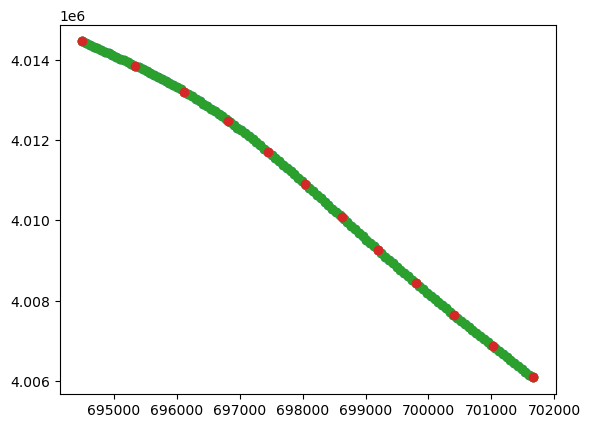

In [113]:
filtered = depth_pts[depth_pts['Z'] >= -3200]
X = filtered['X'].values.reshape(-1, 1)
y = filtered['Y'].values
# Set up Gaussian Process
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1e4, length_scale_bounds="fixed")
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gp.fit(X, y)
# Prediction grid
xs_shallow_depth = np.linspace(X.min(), X.max(), 120).reshape(-1, 1)
print(min(xs_shallow_depth),max(xs_shallow_depth))
shallow_depth = gp.predict(xs_shallow_depth)

plt.scatter(xs_shallow_depth,shallow_depth)
plt.scatter(X,y)


[694853.23982432] [701464.41344639]


/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


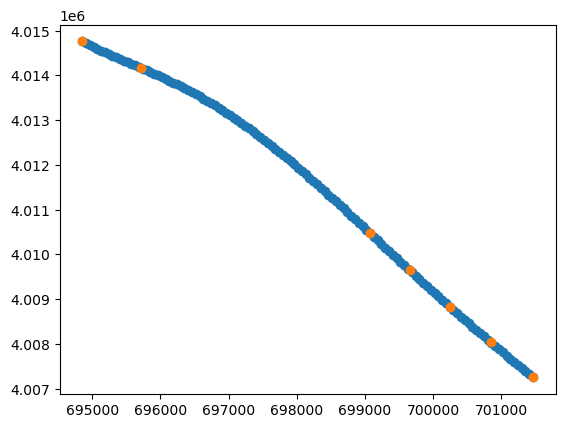

In [119]:
filtered = depth_pts[depth_pts['Z'] <= -5000]
X = filtered['X'].values.reshape(-1, 1)
y = filtered['Y'].values
# Set up Gaussian Process
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1e4, length_scale_bounds="fixed")
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gp.fit(X, y)
# Prediction grid
xs_deep_depth = np.linspace(X.min(), X.max(), 120).reshape(-1, 1)
print(min(xs_deep_depth),max(xs_deep_depth))
deep_depth = gp.predict(xs_deep_depth)

plt.scatter(xs_deep_depth,deep_depth)
plt.scatter(X,y)

[694215.82373414] [697867.07373414]


/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


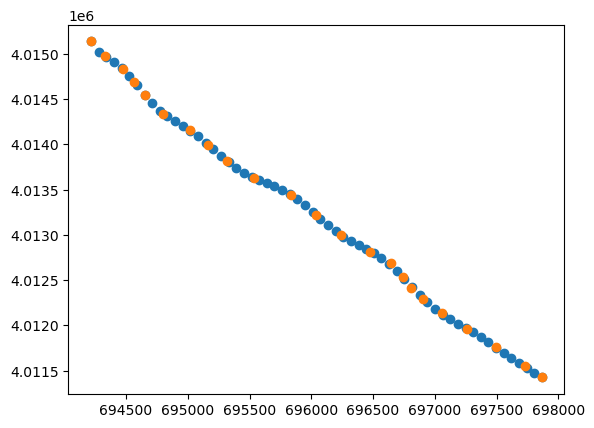

In [8]:
filtered = nesurf_pts
X = filtered['X'].values.reshape(-1, 1)
y = filtered['Y'].values
# Set up Gaussian Process
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1e3, length_scale_bounds="fixed")
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gp.fit(X, y)
# Prediction grid
xs_ne_surf = np.linspace(X.min(), X.max(), 60).reshape(-1, 1)
print(min(xs_ne_surf),max(xs_ne_surf))
ne_surf = gp.predict(xs_ne_surf)

plt.scatter(xs_ne_surf,ne_surf)
plt.scatter(X,y)

[695143.62928969] [701693.97187662]


/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


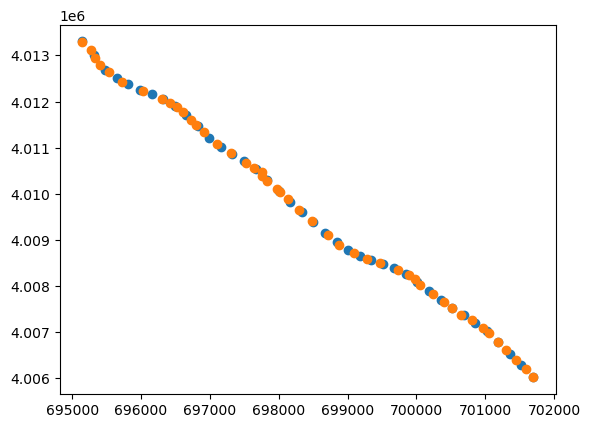

In [9]:
filtered = swsurf_pts
X = filtered['X'].values.reshape(-1, 1)
y = filtered['Y'].values
# Set up Gaussian Process
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1e3, length_scale_bounds="fixed")
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gp.fit(X, y)
# Prediction grid
xs_sw_surf = np.linspace(X.min(), X.max(), 40).reshape(-1, 1)
print(min(xs_sw_surf),max(xs_sw_surf))
sw_surf = gp.predict(xs_sw_surf)

plt.scatter(xs_sw_surf,sw_surf)
plt.scatter(X,y)

In [115]:
# Extend shallow depth to deep depth
  
nfault_pts = len(np.arange(0,3000,100)) * len(sw_surf) + len(np.arange(0,3000,100)) * len(ne_surf) + len(np.arange(3000,5500,100)) * len(shallow_depth)

X, Y, Z = np.empty(nfault_pts), np.empty(nfault_pts), np.empty(nfault_pts)
ids = np.empty(nfault_pts)
# Build a KDTree for the points in list_B
tree = KDTree(np.column_stack([xs_deep_depth,deep_depth]))
distances, indices = tree.query(np.column_stack([xs_shallow_depth,shallow_depth]))

for i,depth in enumerate(np.arange(3000,5500,100)):
    # Find closest point
    fraction = (depth - 3000) / (-3000 + 5500)
    x = xs_shallow_depth + fraction * (xs_deep_depth[indices]-xs_shallow_depth)
    y = shallow_depth + fraction * (deep_depth[indices]-shallow_depth)

    X[i*len(x):i*len(x)+len(x)] = x.flatten()
    Y[i*len(x):i*len(x)+len(x)] = y.flatten()
    Z[i*len(x):i*len(x)+len(x)] = np.ones(len(x))*-1*depth
    ids[i*len(x):i*len(x)+len(x)] = np.ones(len(x))*2

i_prev = i*len(x)+len(x)

# Build a KDTree for the points in list_B
tree = KDTree(np.column_stack([xs_shallow_depth,shallow_depth]))
distances, indices = tree.query(np.column_stack([xs_ne_surf,ne_surf]))

for i,depth in enumerate(np.arange(0,3000,100)):
    # Find closest point
    fraction = (depth + 0) / (-0 + 3000)
    x = xs_ne_surf + fraction * (xs_shallow_depth[indices]-xs_ne_surf)
    y = ne_surf + fraction * (shallow_depth[indices]-ne_surf)

    X[i_prev+i*len(x):i_prev+i*len(x)+len(x)] = x.flatten()
    Y[i_prev+i*len(x):i_prev+i*len(x)+len(x)] = y.flatten()
    Z[i_prev+i*len(x):i_prev+i*len(x)+len(x)] = np.ones(len(x))*-1*depth
    ids[i_prev+i*len(x):i_prev+i*len(x)+len(x)] = np.ones(len(x))*2

i_prev = i_prev+i*len(x)+len(x)

# Build a KDTree for the points in list_B
tree = KDTree(np.column_stack([xs_shallow_depth,shallow_depth]))
distances, indices = tree.query(np.column_stack([xs_sw_surf,sw_surf]))

for i,depth in enumerate(np.arange(0,3000,100)):
    # Find closest point
    fraction = (depth + 0) / (-0 + 3000)
    x = xs_sw_surf + fraction * (xs_shallow_depth[indices]-xs_sw_surf)
    y = sw_surf + fraction * (shallow_depth[indices]-sw_surf)

    X[i_prev+i*len(x):i_prev+i*len(x)+len(x)] = x.flatten()
    Y[i_prev+i*len(x):i_prev+i*len(x)+len(x)] = y.flatten()
    Z[i_prev+i*len(x):i_prev+i*len(x)+len(x)] = np.ones(len(x))*-1*depth
    ids[i_prev+i*len(x):i_prev+i*len(x)+len(x)] = np.ones(len(x))*2




In [ ]:
fltpts = pd.DataFrame({'X':X,'Y':Y,'Z':Z,'ID':ids})
#fltpts.to_csv('/Volumes/ProjectsGarlockCSAF/CSAF_Lidar/GIS/FinalFaultGeomFiles/FaultPointsMRMR.csv',index=False)


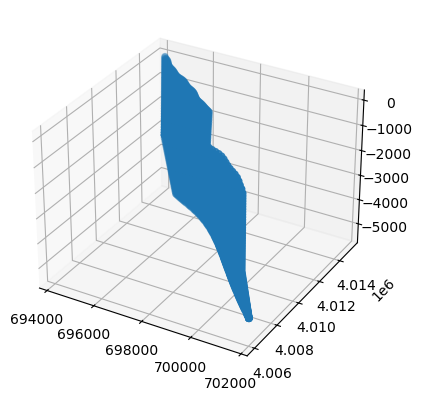

In [116]:
%matplotlib inline
ax = plt.figure().add_subplot(projection='3d',)
ax.scatter(X,Y,Z)

## Old

In [ ]:
from rasterio.warp import reproject, Resampling
from affine import Affine
import numpy as np


def rotate_raster(in_file,out_file, angle, shift_x=0, shift_y=0,adj_width=0, adj_height=0):
    """Rotate a raster image and save it to disk.
            in_file: path to input raster file
            out_file: path to output raster file
            angle: angle of rotation in degrees
            shift_x: shift in x direction
            shift_y: shift in y direction
            adj_width: adjust width of output raster
            adj_height: adjust height of output raster"""

    with rasterio.open(in_file) as src:

        # Get the old transform and crs
        src_transform = src.transform 
        nodata = src.nodata if src.nodata is not None else -9999
        crs = src.crs

        # Affine transformations for rotation and translation
        rotate = Affine.rotation(angle)
        trans_x = Affine.translation(shift_x,0)
        trans_y = Affine.translation(0, -shift_y)

        # Combine affine transformations
        dst_transform = src_transform * rotate * trans_x * trans_y

        # Get band data
        band = np.array(src.read(1))

        # Get the new shape
        y,x = band.shape
        dst_height = y + adj_height
        dst_width = x + adj_width

        # set properties for output
        dst_kwargs = src.meta.copy()
        dst_kwargs.update(
            {
                "transform": dst_transform,
                "height": dst_height,
                "width": dst_width,
                "nodata": nodata  
            }
        )

        # write to disk
        with rasterio.open(out_file, "w", **dst_kwargs) as dst:
            # reproject to new CRS

            reproject(source=band,
                        destination=rasterio.band(dst, 1),
                        src_transform=src_transform,
                        src_crs=crs,
                        dst_transform=dst_transform,
                        dst_crs=crs,
                        resampling=Resampling.nearest)

# Example usage

input_raster = "/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/2018_dem_MRMR_mosaic_202412.tif"
input_raster = "/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/2007_dem_MRMR_mosaic_202412.tif"
output_raster = "/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/2018_dem_MRMR_mosaic43cw_202412.tif"
output_raster = "/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/2007_dem_MRMR_mosaic43cw_202412.tif"
rotation_angle = -43  # Angle in degrees (clockwise)


#rotate_raster(input_raster, output_raster, rotation_angle,shift_x=-5000,shift_y=-2500,adj_width=-27000, adj_height=6000)


In [20]:
output_raster1 = "/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/2018_dem_MRMR_mosaic_202412.tif"
output_raster2 = "/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/2007_dem_MRMR_mosaic_202412.tif"

results = return_common_extent_rasters([output_raster1],[output_raster2])

In [34]:
im2, im1 = results[0][0][0], results[0][1][0]
nodata_mask = ((im2 == -9999) & (im1 == -9999))
im1[nodata_mask] = np.nan
im2[nodata_mask] = np.nan
res = im2 - im1

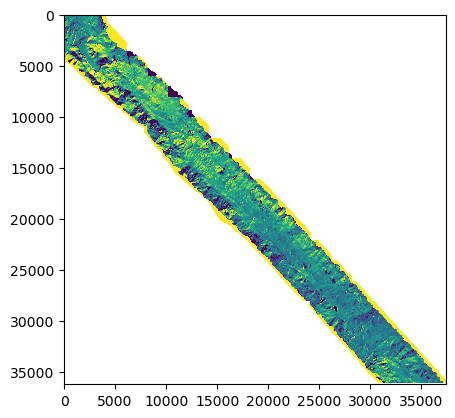

In [35]:
plt.imshow(res,vmin=-0.3,vmax=0.3)

(ulx, uly, lrx, lry)
	1 bounding box: [673948.6290171593, 4039051.1769158137, 678352.1290171593, 4033948.1769158137]
	2 bounding box: [673948.6290171593, 4039051.1769158137, 678433.1290171593, 4033948.6769158137]
minx, miny, maxx, maxy:
673948.6290171593 4033948.6769158137 678352.1290171593 4039051.1769158137


In [11]:
inf = '/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/2007_dem_TC_mosaic_aspAligned_202412.tif'
outf = '/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/mm2007_dem_TC_mosaic_aspAligned_202412.tif'
tt.micmacExport(inf,outf,outres=[0.5,-0.5],a_ullr=[olap[0],olap[3],olap[2],olap[1]])
inf = '/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/2018_dem_TC_mosaic_202412.tif'
outf = '/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/mm2018_dem_TC_mosaic_202412.tif'
tt.micmacExport(inf,outf,outres=[0.5,-0.5],a_ullr=[olap[0],olap[3],olap[2],olap[1]])

nohup taskset -c 0-64 mm3d Mm2dPosSism 2007_dem_TC_mosaic_aspAligned_202412.tif 2018_dem_TC_mosaic_202412.tif CorMin=0.1 Dequant=false DirMEC='MEC_TC/' &


Writing to /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/mm2007_dem_TC_mosaic_aspAligned_202412.tif
Writing to /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/mm2018_dem_TC_mosaic_202412.tif


In [16]:
tt.micmacPostProcessing(folder='/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/MEC_TC/',
                         prefile='/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/2007_dem_TC_mosaic_aspAligned_202412.tif',#predem
                         outprefix='/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/MEC_TC/')

folder = '/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/MEC_TC/'
par, perp = tt.projectDisp(folder+'EWmicmac.tif',folder+'NSmicmac.tif',-45,mask=None,partif=folder+'ParallelDisp.tif',perptif=folder+'PerpendicularDisp.tif')

Saving /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/MEC_TC/NSmicmac.tif
Saving /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/MEC_TC/EWmicmac.tif
Saving /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/MEC_TC/Correlmicmac.tif


In [51]:
tt.micmacPostProcessing(folder='/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/MEC/',
                         prefile='/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/2007_dem_MRMR_mosaic_202412.tif',#predem
                         outprefix='/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/MEC/')

Saving /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/MEC/NSmicmac.tif
Saving /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/MEC/EWmicmac.tif
Saving /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/MEC/Correlmicmac.tif


In [ ]:
folder = '/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/MEC/'
par, perp = tt.projectDisp(folder+'EWmicmac.tif',folder+'NSmicmac.tif',-45,mask=None,partif=folder+'ParallelDisp.tif',perptif=folder+'PerpendicularDisp.tif')

In [3]:
tt.micmacPostProcessing(folder='/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/MEC_TC/',
                         prefile='/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/2007_dem_TC_mosaic_aspAligned_202412.tif',#predem
                         outprefix='/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/MEC_TC/')

folder = '/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/MEC_TC/'


tt.verticalDispExtentAgnosticBilinInterp(folder[:-4]+'2007_dem_MRMR_mosaic_202412.tif',folder[:-4]+'2018_dem_MRMR_mosaic_202412.tif',folder+'NSmicmac.tif',folder+'EWmicmac.tif',outf=folder+'UDmicmac.tif')

array([[-9999.   , -9999.   , -9999.   , ..., -9999.   , -9999.   ,
        -9999.   ],
       [-9999.   , -9999.   , -9999.   , ..., -9999.   , -9999.   ,
        -9999.   ],
       [-9999.   , -9999.   , -9999.   , ..., -9999.   , -9999.   ,
        -9999.   ],
       ...,
       [-9999.   , -9999.   , -9999.   , ..., 10556.991, 10556.812,
        10556.655],
       [-9999.   , -9999.   , -9999.   , ..., 10557.02 , 10556.858,
        10556.638],
       [-9999.   , -9999.   , -9999.   , ..., 10557.077, 10556.874,
        10556.696]], dtype=float32)

In [ ]:
# Load ortho
image = rioxarray.open_rasterio('/Volumes/Extreme Pro/big_data/LidarCSAFtiffs/MEC/EWmicmac.tif')
dE = image.rio.reproject("EPSG:4326")
dE.data[dE.data == -9999] = np.nan
dE = dE - dE.mean()
# Load ortho
image = rioxarray.open_rasterio('/Volumes/Extreme Pro/big_data/LidarCSAFtiffs/MEC/NSmicmac.tif')
dN = image.rio.reproject("EPSG:4326")
dN.data[dN.data == -9999] = np.nan
dN = dN - dN.mean()

In [ ]:
# Load ortho
image = rioxarray.open_rasterio('/Volumes/Extreme Pro/big_data/LidarCSAFtiffs/MEC/ParallelDisp.tif')
dP = image.rio.reproject("EPSG:4326")
dP.data[dP.data == -9999] = np.nan
dP = dP - dP.mean()

In [ ]:
latlon = np.meshgrid(dN.x.data,dN.y.data)

In [17]:
subregion = [-120.818512, 36.219191, -120.785624, 36.232056]
subregion = [-120.86102, 36.16672,-120.72018,36.26133] 

In [6]:
boo = (latlon[0] > subregion[0])&(latlon[0] < subregion[2])&(latlon[1] > subregion[1])&(latlon[1] < subregion[3])


In [75]:
df.dx.values

array([-1.49653622, -1.49653622,         nan, ...,         nan,
               nan, -3.76926349])

In [73]:
dE.data[0][boo][::skip].flatten()/(2018-2007)*1000

array([-1.49653622, -1.49653622,         nan, ...,         nan,
               nan, -3.76926349])

In [78]:

skip = 100000
df = pd.DataFrame({'lon':latlon[0][boo][::skip].flatten(),'lat':latlon[1][boo][::skip].flatten(),'dx':dE.data[0][boo][::skip].flatten(),'dy':dN.data[0][boo][::skip].flatten(),})
df = df[~np.isnan(df.dx.values)]
df.dx = (df.dx)/(2018-2007)*1000
df.dy = (df.dy)/(2018-2007)*1000

In [25]:
# pea1 minus pea2
navg = (12.95+33.01)/2
eavg = (-10.11+-27.62)/2
p1 =  pd.DataFrame({'lon':[-120.7586],'lat':[36.18691],'dx':[-10.11-eavg],'dy':[12.95-navg]})
p2 =  pd.DataFrame({'lon':[-120.76685],'lat':[36.18053],'dx':[-27.62-eavg],'dy':[33.01-navg]})


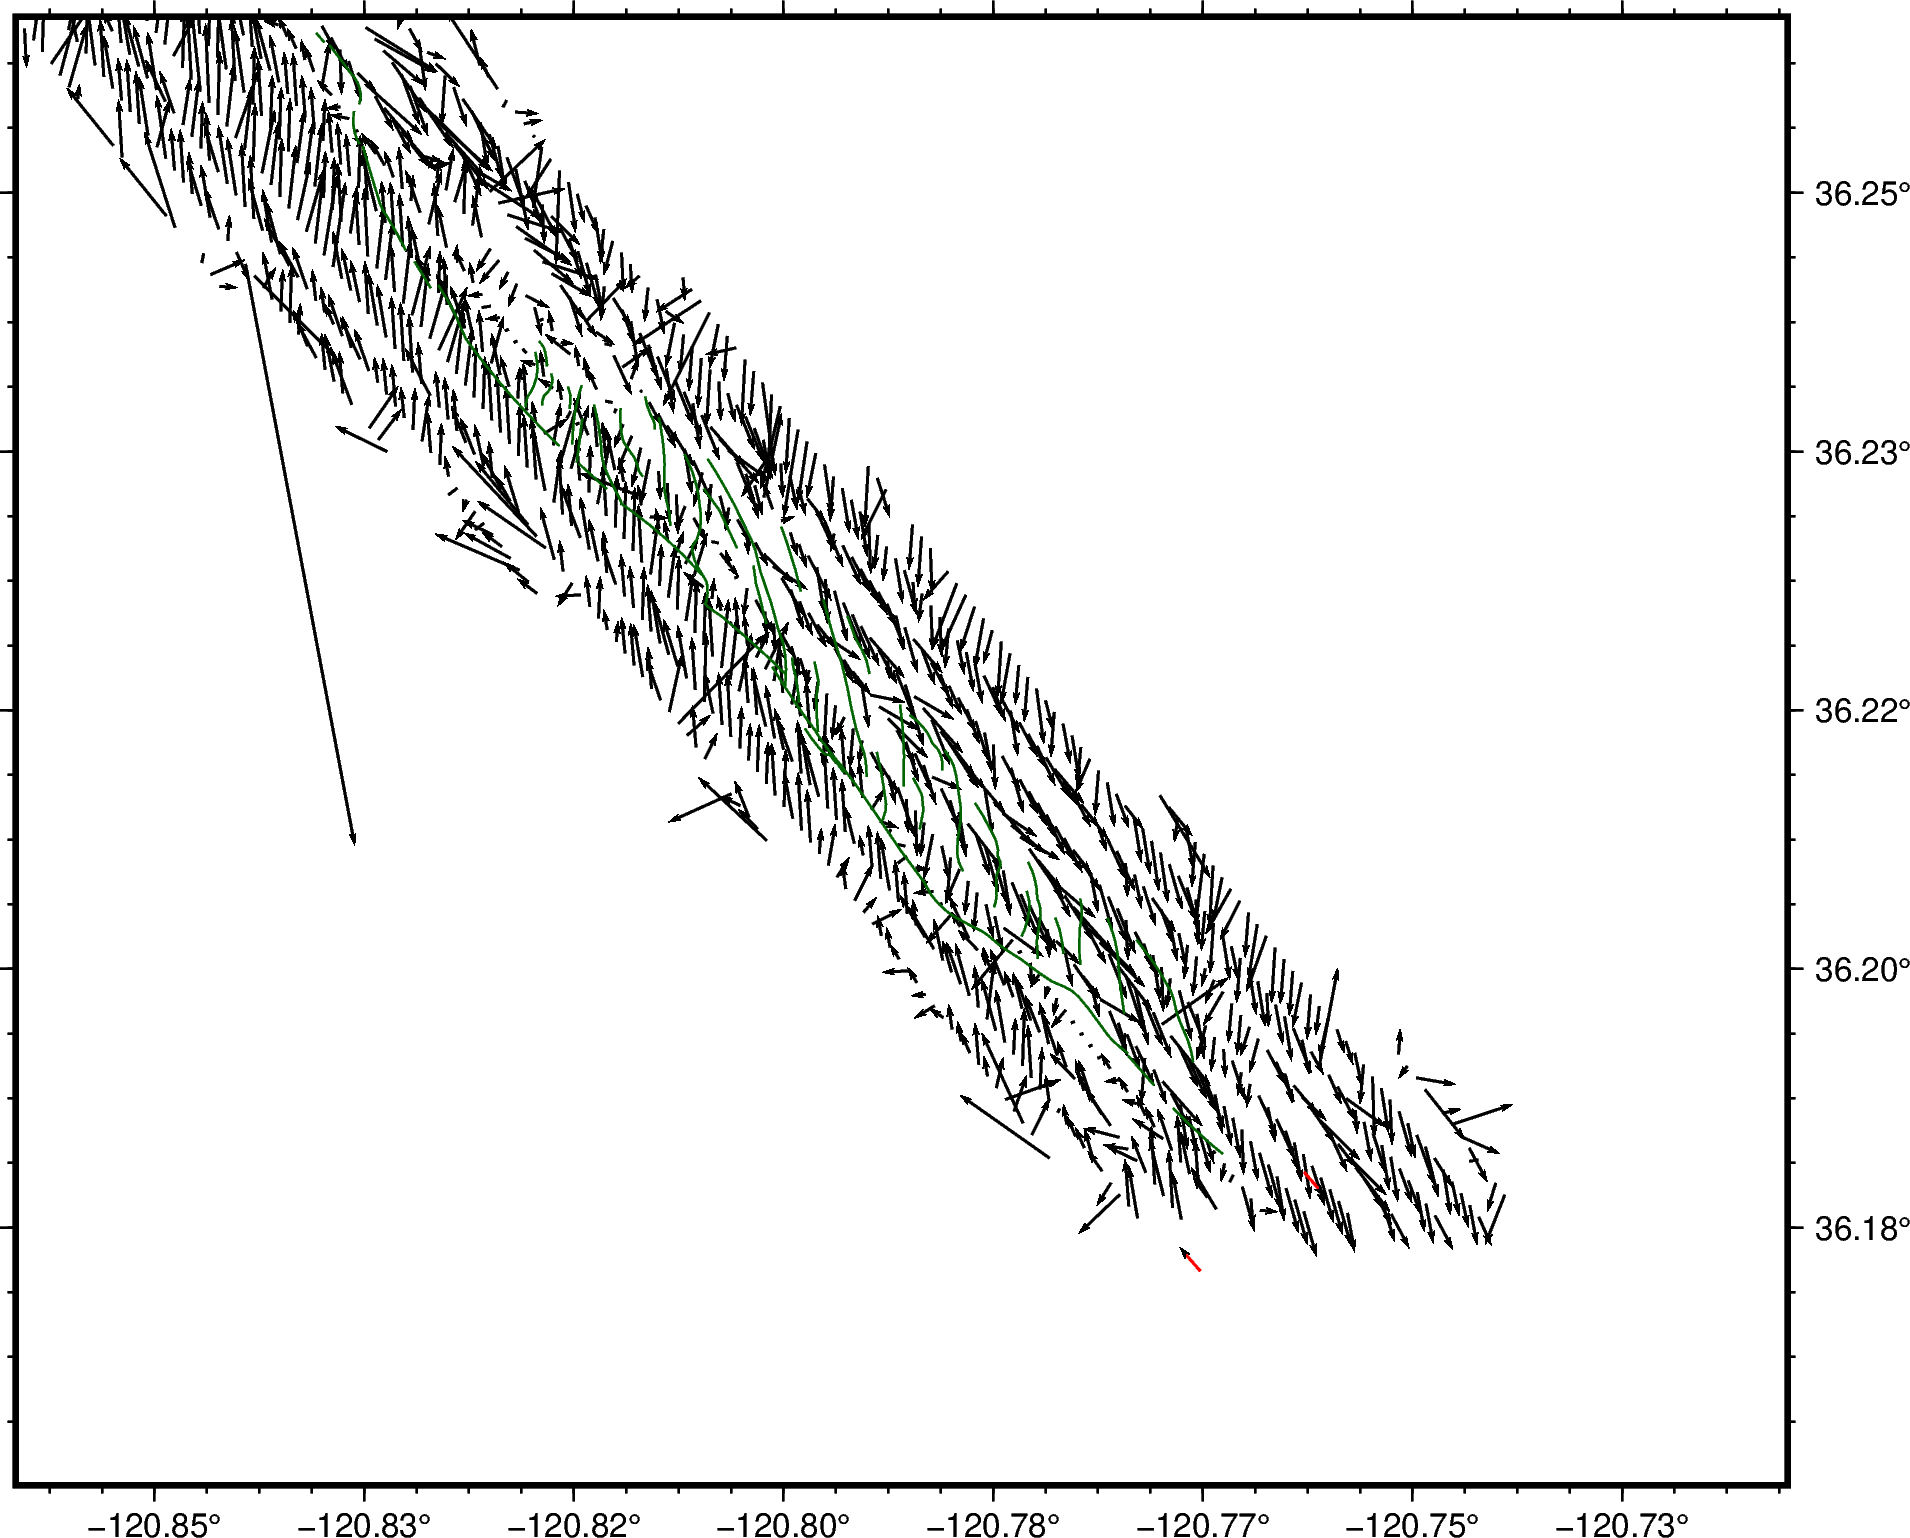

In [79]:
# SUbregion
# Introductory figure base

fig = pygmt.Figure()

# Configuration for the 'current figure'.
pygmt.config(MAP_FRAME_TYPE="plain")
pygmt.config(FORMAT_GEO_MAP="ddd.xx")
pygmt.config(FONT_ANNOT_PRIMARY="8p")
pygmt.config(FONT_ANNOT_SECONDARY="6p")

# Plot the base map of the main figure. 
region = [subregion[0],subregion[2],subregion[1],subregion[3]]
fig.basemap(region=region, projection="M15c", frame=["ESnw", "af"])

# gridimage
pygmt.makecpt(cmap='polar',series=[-0.25,0.25],background='o',reverse=True)
#fig.grdimage(grid=dP,cmap=True)

# vectors, Mee1 and Mee2
fig.velo(df
         ,spec="e0.02/1+f18",
    #uncertaintyfill="lightblue1",
    pen="0.6p,black",
    line=True,
    vector="0.1c+p1p+e+gblack",)
fig.velo(p1
         ,spec="e0.02/1+f18",
    #uncertaintyfill="lightblue1",
    pen="0.6p,red",
    line=True,
    vector="0.1c+p1p+e+gred",)
fig.velo(p2
         ,spec="e0.02/1+f18",
    #uncertaintyfill="lightblue1",
    pen="0.6p,red",
    line=True,
    vector="0.1c+p1p+e+gred",)
# Fault Trace
#pts = pd.read_csv('/Volumes/Extreme Pro/Projects/Garlock/GIS/EastPoints.csv')
#pts.sort_values(by='Lon',ascending=True,inplace=True)
fig.plot('/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Data/Faults/DeLong2010/NewFaultsRevisionEPSG4326.shp',pen="0.5p,darkgreen")

#rectangle = [[e_inset[0], e_inset[2], e_inset[1], e_inset[3]]]
#fig.plot(data=rectangle, style="r+s", pen="0.55p,maroon")


#fig.basemap(map_scale='JBR+w1k+o-2c/-1c+lkm',box="+c0.1/0.3+gwhite@30+p0.5p,grey@30,solid",rose='jBR+l,,,N+o0.5/0.4+w0.75c')
#fig.savefig('/Volumes/Extreme Pro/big_data/LidarCSAFtiffs/MEC/ParallelDisp.pdf',dpi=300)
fig.show()

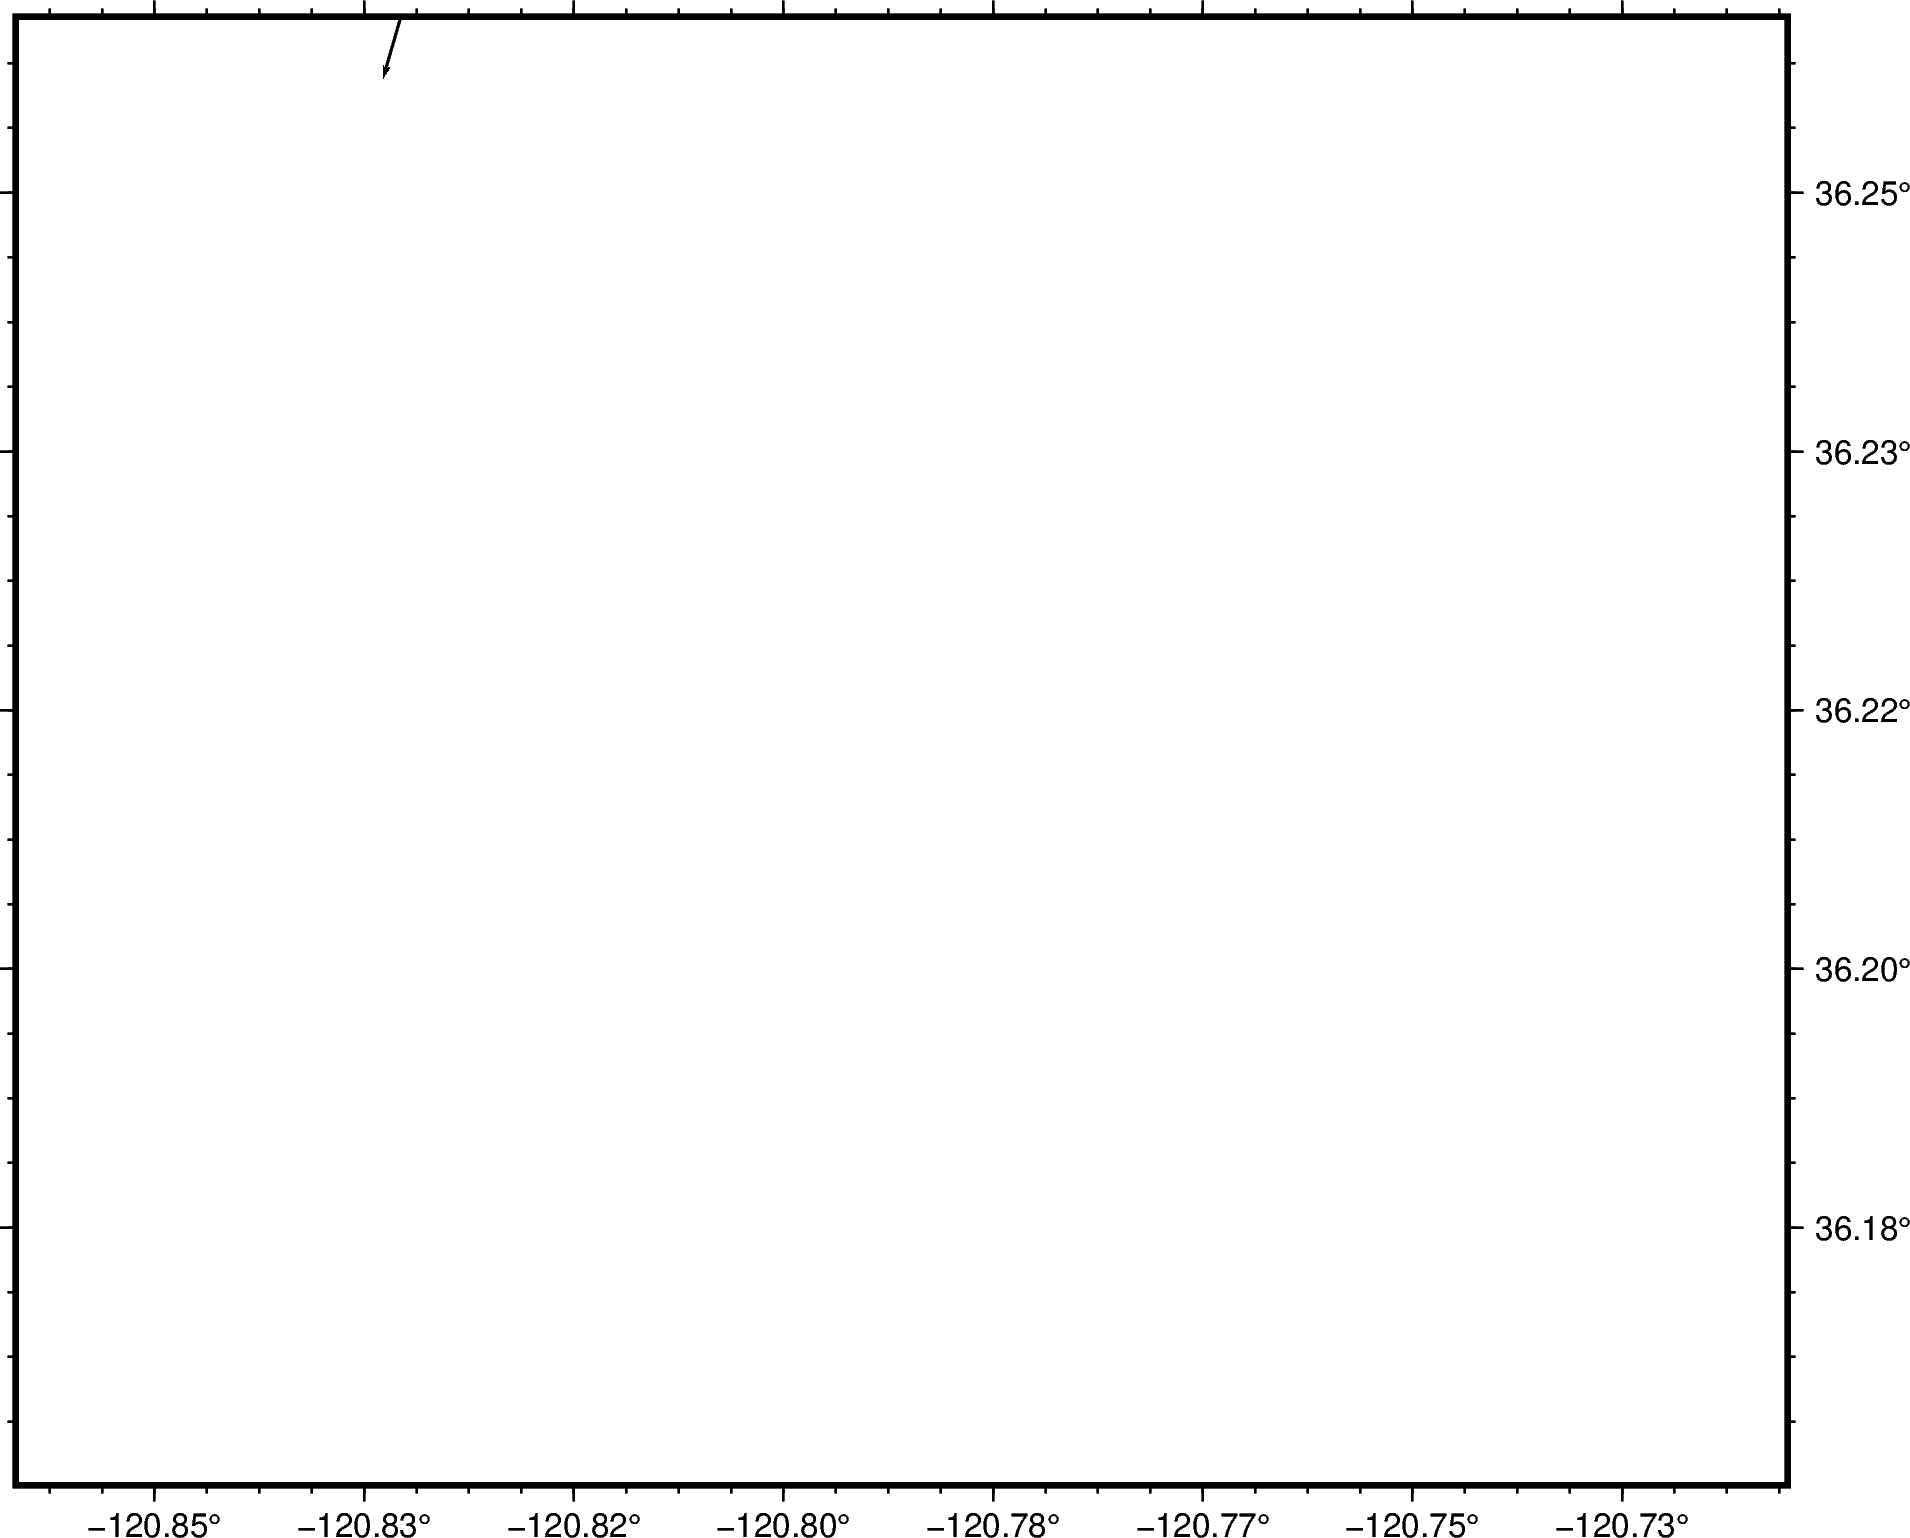

In [49]:
# SUbregion
# Introductory figure base

fig = pygmt.Figure()

# Configuration for the 'current figure'.
pygmt.config(MAP_FRAME_TYPE="plain")
pygmt.config(FORMAT_GEO_MAP="ddd.xx")
pygmt.config(FONT_ANNOT_PRIMARY="8p")
pygmt.config(FONT_ANNOT_SECONDARY="6p")

# Plot the base map of the main figure. 
region = [subregion[0],subregion[2],subregion[1],subregion[3]]
fig.basemap(region=region, projection="M15c", frame=["ESnw", "af"])

# gridimage
pygmt.makecpt(cmap='polar',series=[-0.25,0.25],background='o',reverse=True)
#fig.grdimage(grid=dP,cmap=True)

# vectors, Mee1 and Mee2
fig.velo(df.iloc[1:2]
         ,spec="e0.1/1+f18",
    #uncertaintyfill="lightblue1",
    pen="0.6p,black",
    line=True,
    vector="0.1c+p1p+e+gblack",)

# Fault Trace

#rectangle = [[e_inset[0], e_inset[2], e_inset[1], e_inset[3]]]
#fig.plot(data=rectangle, style="r+s", pen="0.55p,maroon")


#fig.basemap(map_scale='JBR+w1k+o-2c/-1c+lkm',box="+c0.1/0.3+gwhite@30+p0.5p,grey@30,solid",rose='jBR+l,,,N+o0.5/0.4+w0.75c')
#fig.savefig('/Volumes/Extreme Pro/big_data/LidarCSAFtiffs/MEC/ParallelDisp.pdf',dpi=300)
fig.show()

In [48]:
df.


,lon,lat,dx,dy
1,-120.830418,36.261305,-1.496536,-5.168158


In [1]:
im1 = '/Users/chanagan/Desktop/micmac/LidarTests/2007.laz'
im2 = '/Users/chanagan/Desktop/micmac/LidarTests/2018.laz'

a_ullr = [700672.4,4007759.8,702333.6,4006198.6]



 

In [80]:
# ICP window and step sizes
window_size = 50
step_size = 25
extra = 10

In [ ]:
# ICP window and step sizes
window_size = 50
step_size = 25
extra = 10

# Path to pre- and post-event indexed point clouds (EPT)
pre_event_index = im1
post_event_index = im2

# Variables to hold the ICP vector origins (X, Y) and displacements (dx, dy)
X = []
Y = []
dx = []
dy = []

# Slide a window through the analysis area
for x in range(int(a_ullr[0]), int(a_ullr[2]), step_size):
    for y in range(int(a_ullr[3]), int(a_ullr[1]), step_size):

        # PDAL pipeline with data bounds set according to the current window.
        # The first window is 'fixed'; The second window is 'moving'.
        # Note that we pad the 'fixed' window so the second window has room to
        # move within the fixed window as the ICP solution converges.
        pipeline1 = [
            {
                'type':'readers.las',
                'filename':post_event_index
            },
            {
                'type':'filters.crop',
                'bounds':'([{},{}],[{},{}])'.format(x - extra,
                                                    x + window_size + extra,
                                                    y - extra,
                                                    y + window_size + extra)
            },
            {'type':'writers.las',
             'filename':'tmp1.las'}
        ]
        # Execute the pipeline
        p1 = pdal.Pipeline(json.dumps(pipeline1))
        p1.execute()
        pipeline2 = [{
                'type':'readers.las',
                'filename':pre_event_index
            },
            {
                'type':'filters.crop',
                'bounds':'([{},{}],[{},{}])'.format(x,
                                                    x + window_size,
                                                    y,
                                                    y + window_size)
            },
            {'type':'writers.las',
             'filename':'tmp2.las'}
        ]
        # Execute the pipeline
        p2 = pdal.Pipeline(json.dumps(pipeline2))
        p2.execute()
        pipeline3 = ['tmp1.las',
            'tmp2.las',
            {
                'type':'filters.icp'
            }
        ]
        # Execute the pipeline
        p = pdal.Pipeline(json.dumps(pipeline3))
        p.execute()

        # Capture the metadata, which contains the ICP transformation
        m = p.metadata
        t = m.get('metadata').get('filters.icp').get('transform')

        # Store vector origin and ICP-derived displacement
        try:
            t = [float(val) for val in t.split()]
            X.append(x + window_size/2)
            Y.append(y + window_size/2)
            dx.append(t[3])
            dy.append(t[7])
        except:
            pass

        # Print status
        print('Displacement vector at X={}, Y={}: dx={}, dy={}'.format(
            X[-1], Y[-1], dx[-1], dy[-1]))

# Plot the ICP vectors
plt.figure()
plt.quiver(X, Y, dx, dy, angles='xy', scale_units='xy')
plt.axis('equal')
plt.show()

# Results

In [4]:
import numpy as np
import pandas as pd

In [ ]:
#df = pd.DataFrame({'X':X,'Y':Y,'dx':dx,'dy':dy})
#df.to_csv('LidarDiffResults.txt',sep='\t',index=False)
df = pd.read_csv('LidarDiffResults.txt',sep='\s+')


In [60]:
# Filter out implausible displacements based on window size
id = df[(df['dx'] >= 50) | (df['dx'] <= -50) | (df['dy'] >= 50) | (df['dy'] <= -50)].projected_displacement.index

In [62]:
fdf = df#df[(df['dx'] <= 50) & (df['dx'] >= -50) & (df['dy'] <= 50) & (df['dy'] >= -50)]

In [63]:
# Assuming you have already created the dataframe df
azimuth = 315  # Azimuth angle in degrees
theta = np.radians(azimuth)  # Convert azimuth angle to radians
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])

# Rotate displacements by 45 degrees clockwise
displacements_rotated = np.dot(rotation_matrix, np.array([fdf['dx'].values, fdf['dy'].values]))

# Project displacements onto x-axis (parallel to the azimuth)
projected_displacements = displacements_rotated[0]

# Add the projected displacements to the dataframe
fdf['projected_displacement'] = projected_displacements
fdf.loc[id,['dx','dy','projected_displacement']] = -9999

In [ ]:
# Plot the ICP vectors
plt.figure()
plt.quiver(fdf.X, fdf.Y, fdf.dx, fdf.dy, angles='xy', scale_units='xy',scale=0.01)
plt.axis('equal')
plt.show()

In [ ]:
plt.scatter(fdf[fdf.projected_displacement!=-9999].X,fdf[fdf.projected_displacement!=-9999].Y,c=fdf[fdf.projected_displacement!=-9999].projected_displacement)

In [ ]:
import sys
sys.path.append('../Functions')
import TiffTools as tt

from osgeo import gdal

%load_ext autoreload
%autoreload 2

In [135]:
# create dem
pipeline1 = [
        im1,
        {
            "filename":"/Users/chanagan/Desktop/micmac/LidarTests/2007.tif",
            "gdaldriver":"GTiff",
            "output_type":"min",
            "resolution":"0.5",
            "type": "writers.gdal"
        }
    ]
# create dem
pipeline2 = [
        im2,
        {
            "filename":"/Users/chanagan/Desktop/micmac/LidarTests/2018.tif",
            "gdaldriver":"GTiff",
            "output_type":"min",
            "resolution":"0.5",
            "type": "writers.gdal"
        }
    ]

In [ ]:
p = pdal.Pipeline(json.dumps(pipeline1))
p.execute()

In [ ]:
im = gdal.Open('/Users/chanagan/Desktop/micmac/LidarTests/2018.tif')

In [15]:
band = im.GetRasterBand(1).ReadAsArray()

In [108]:
arr = np.zeros([len(fdf.Y.unique()), len(fdf.X.unique())])

In [118]:
for i,y in enumerate(fdf.Y.unique()):
    for j,x in enumerate(fdf.X.unique()):
        arr[len(fdf.Y.unique()) - i -1,j] = fdf[(fdf.X == x) & (fdf.Y == y)].projected_displacement.values[0]

In [ ]:
tmp = arr
tmp[tmp == -9999] = np.nan
plt.imshow(arr)

In [120]:
gt = (im.GetGeoTransform()[0],step_size,0.0,im.GetGeoTransform()[3],0.0,-step_size)

In [121]:
#tt.save_geotiff(arr, '/Users/chanagan/Desktop/micmac/LidarTests/projected_displacement.tif', geotransform=gt, projection=im.GetProjection(),nodata=-9999)

## DEM pixel offset tracking

In [ ]:
687898 4006366 703244 4019362

In [ ]:
# Projected displacements
azimuth = 315
folder = '/Users/chanagan/Desktop/micmac/WV_Aerial_to2023/dems/MEC/'

tt.micmacPostProcessing(folder=folder,
                         prefile='/Users/chanagan/Desktop/micmac/WV_Aerial_to2023/dems/2009dem.tif',
                        outprefix=folder)

cor = gdal.Open(folder+'Correlmicmac.tif')
mask = (cor.GetRasterBand(1).ReadAsArray() > 0.5)
ewtif = folder+'EWmicmac.tif'
nstif = folder+'NSmicmac.tif'
print('Working in',folder)
par, perp = tt.projectDisp(ewtif,nstif,azimuth,mask=mask,partif=folder+'ParallelDisp.tif',perptif=folder+'PerpendicularDisp.tif')

In [ ]:
# create a hillshade
#!gdaldem hillshade /Users/chanagan/Desktop/micmac/LidarTests/2018.tif /Users/chanagan/Desktop/micmac/LidarTests/2018hillshade.tif -of GTiff -b 1 -z 1.0 -s 1.0 -az 315.0 -alt 45.0
#!gdaldem hillshade /Users/chanagan/Desktop/micmac/LidarTests/2007.tif /Users/chanagan/Desktop/micmac/LidarTests/2007hillshade.tif -of GTiff -b 1 -z 1.0 -s 1.0 -az 315.0 -alt 45.0
# Rotate raster


In [152]:
im = gdal.Open('/Users/chanagan/Desktop/micmac/WV_Aerial_to2023/orthos/09AUG04WVortho.tif')
band = im.GetRasterBand(1).ReadAsArray()

In [ ]:
ogt = im.GetGeoTransform()
gt = (ogt[0],ogt[1],np.pi/2,ogt[3],np.pi/2,ogt[5])
gt

In [160]:
tt.save_geotiff(band,'/Users/chanagan/Desktop/micmac/WV_Aerial_to2023/orthos/09AUG04WVortho_rotated.tif', geotransform=gt, projection= im.GetProjection(),nodata=-9999)

In [ ]:
9000+300*9

In [ ]:
import numpy as np
import open3d as o3d
from scipy.spatial import KDTree

def windowed_icp(source, target, window_size, max_iterations=50, tolerance=1e-4):
    """
    Performs windowed Iterative Closest Point (ICP) registration.

    Args:
        source (open3d.geometry.PointCloud): Source point cloud.
        target (open3d.geometry.PointCloud): Target point cloud.
        window_size (float): Window size for neighbor search.
        max_iterations (int): Maximum number of ICP iterations.
        tolerance (float): Convergence tolerance.

    Returns:
        open3d.pipelines.registration.RegistrationResult: ICP registration result.
    """

    transformation = np.eye(4) 
    for _ in range(max_iterations):
        source_np = np.asarray(source.points)
        target_np = np.asarray(target.points)

        kdtree = KDTree(target_np)
        distances, indices = kdtree.query(source_np, k=1, distance_upper_bound=window_size)

        # Filter points outside the window
        valid_indices = np.where(distances < window_size)[0]
        source_windowed = source.select_by_index(valid_indices)
        target_windowed = target.select_by_index(indices[valid_indices])

        reg_result = o3d.pipelines.registration.registration_icp(
            source_windowed, target_windowed, 0.02, transformation, 
            o3d.pipelines.registration.TransformationEstimationPointToPoint()
        )

        transformation = reg_result.transformation

        if reg_result.inlier_rmse < tolerance:
            break

    return reg_result

In [ ]:
def compute_transformation(source, target):
    """
    Computes the optimal rigid transformation (rotation and translation) using SVD.

    Args:
        source: Source point cloud (numpy array, shape: (n, 3))
        target: Target point cloud (numpy array, shape: (n, 3))

    Returns:
        Rotation matrix (numpy array, shape: (3, 3))
        Translation vector (numpy array, shape: (3,))
    """

    source_centroid = np.mean(source, axis=0)
    target_centroid = np.mean(target, axis=0)

    source_centered = source - source_centroid
    target_centered = target - target_centroid

    H = np.dot(source_centered.T, target_centered)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = np.dot(Vt.T, U.T)

    t = target_centroid - np.dot(R, source_centroid)

    return R, t

In [8]:
import open3d as o3d, copy
import numpy as np
import rasterio
import matplotlib.pyplot as plt

In [2]:
fpost = '/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/2023deformedDEM-rio-f32.tif' 
postim = rasterio.open(fpost)
fpre = '/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/2020GarlockEastDEM-cropped-f32.tif'
preim = rasterio.open(fpre)

In [4]:
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])

In [129]:
postd = postim.read(1)[sy+int(window*0.05):ey-int(window*0.05),sx+int(window*0.05):ex-int(window*0.05)] # fix for this

xy_post = np.meshgrid(np.arange(sx+int(window*0.05),ex-int(window*0.05)),np.arange(sy+int(window*0.05),ey-int(window*0.05)))


In [133]:
xy_post

(array([[4905, 4906, 4907, ..., 4992, 4993, 4994],
        [4905, 4906, 4907, ..., 4992, 4993, 4994],
        [4905, 4906, 4907, ..., 4992, 4993, 4994],
        ...,
        [4905, 4906, 4907, ..., 4992, 4993, 4994],
        [4905, 4906, 4907, ..., 4992, 4993, 4994],
        [4905, 4906, 4907, ..., 4992, 4993, 4994]]),
 array([[10905, 10905, 10905, ..., 10905, 10905, 10905],
        [10906, 10906, 10906, ..., 10906, 10906, 10906],
        [10907, 10907, 10907, ..., 10907, 10907, 10907],
        ...,
        [10992, 10992, 10992, ..., 10992, 10992, 10992],
        [10993, 10993, 10993, ..., 10993, 10993, 10993],
        [10994, 10994, 10994, ..., 10994, 10994, 10994]]))

In [137]:
window = 100

# Search distance for Nearest Neighbour Search [Hybrid-Search is used].
threshold = 2
max_iter = 1000
trans_init = np.eye(4)

dx = np.zeros((int(postim.height/window),int(postim.width/window)))
dy = np.zeros((int(postim.height/window),int(postim.width/window)))
dz = np.zeros((int(postim.height/window),int(postim.width/window)))

for x in np.arange(int(0/window),int(5000/window)):#range(0,int(postim.width/window)):
    print(f'On {x}/{int(postim.width/window)}')
    for y in np.arange(int(9000/window),int(11000/window)):#range(0,int(postim.height/window)):
        #while (x*window+window <= postim.width) & (y*window+window <= postim.height):
        sx, ex = int(x*window),   int(x*window+window)    
        sy, ey = int(y*window),   int(y*window+window)    

        postd = postim.read(1)[sy+int(window*0.05):ey-int(window*0.05),sx+int(window*0.05):ex-int(window*0.05)] # fix for this
        pred = preim.read(1)[sy:ey,sx:ex]

        xy_post = np.meshgrid(np.arange(sx+int(window*0.05),ex-int(window*0.05)),np.arange(sy+int(window*0.05),ey-int(window*0.05)))
        xy_pre = np.meshgrid(np.arange(sx,ex),np.arange(sy,ey))

        pts = np.float64(np.column_stack([xy_post[0].flatten(),xy_post[1].flatten(),postd.flatten()]))
        source = o3d.geometry.PointCloud()
        source.points = o3d.utility.Vector3dVector(pts)
        source.remove_non_finite_points() # remove nan
        pts = np.float64(np.column_stack([xy_pre[0].flatten(),xy_pre[1].flatten(),pred.flatten()]))
        target = o3d.geometry.PointCloud()
        target.points = o3d.utility.Vector3dVector(pts)
        target.remove_non_finite_points() # remove nan

        reg_p2p = o3d.pipelines.registration.registration_icp(
                    source, target, threshold, trans_init,
                    o3d.pipelines.registration.TransformationEstimationPointToPoint(),
                    o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=max_iter))
        
        #draw_registration_result(source,target,reg_p2p.transformation)
        print(reg_p2p.transformation)
        dx[y,x] = reg_p2p.transformation[0,-1]
        dy[y,x] = reg_p2p.transformation[1,-1]
        dz[y,x] = reg_p2p.transformation[2,-1]

On 0/228
[[ 9.99999681e-01  1.92667484e-05  7.98193479e-04 -7.61594697e-01]
 [-1.91019945e-05  9.99999979e-01 -2.06415668e-04  1.53006654e-01]
 [-7.98197438e-04  2.06400355e-04  9.99999660e-01 -1.89466558e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 9.99999163e-01  3.63612905e-05  1.29319709e-03 -1.27714866e+00]
 [-3.63873506e-05  9.99999999e-01  2.01282208e-05 -1.28918101e-02]
 [-1.29319635e-03 -2.01752600e-05  9.99999164e-01  1.41733899e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 9.99999802e-01  2.74925292e-05  6.28130939e-04 -7.09642068e-01]
 [-2.79875986e-05  9.99999689e-01  7.88167537e-04 -5.67115320e-01]
 [-6.28109075e-04 -7.88184961e-04  9.99999492e-01  7.19311433e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 9.99998711e-01  1.70627827e-05  1.60579104e-03 -1.31638975e+00]
 [-1.42682477e-05  9.99998486e-01 -1.74028093e-03  1.26868618e+00]
 [-1.60581830e-03  1.74025578e-03  9.99997196e-01 

In [116]:
reg_p2p

RegistrationResult with fitness=1.000000e+00, inlier_rmse=2.297656e-01, and correspondence_set size of 8100
Access transformation to get result.

(0.0, 50.0)

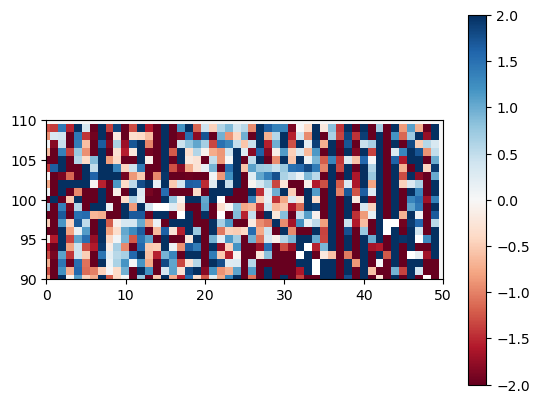

In [156]:
arr = dx.copy().T
mask = ((arr < 10) & (arr > -10))
arr[~mask] = np.nan
plt.imshow(arr,cmap='RdBu',vmin=-2,vmax=2)
plt.colorbar()
plt.ylim(int(9000/window),int(11000/window))
plt.xlim(int(0/window),int(5000/window))

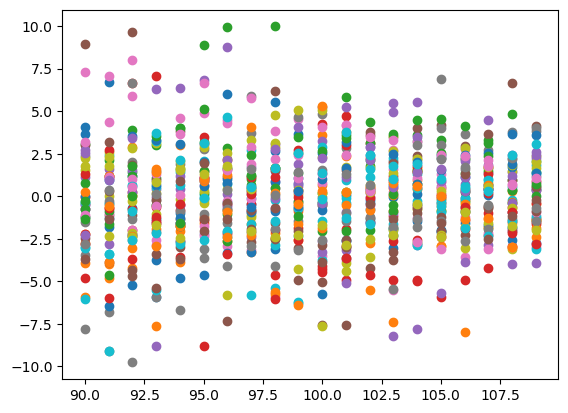

In [159]:
for i in range(0,50):
    plt.scatter(np.arange(90,110),arr[90:110,i])

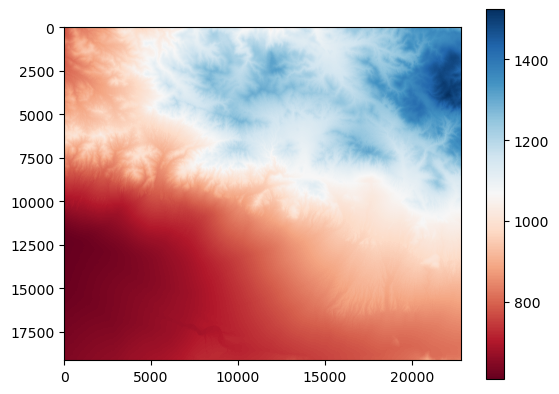

In [32]:
arr = preim.read(1)
plt.imshow(arr,cmap='RdBu')#,vmin=-0.5,vmax=0.5)
plt.colorbar()

In [85]:
# Read image sections for current window
postd = postim.read(1) # smaller post window size
pred = preim.read(1)
# Create mesh grids and flatten to form point clouds
xy_post = np.meshgrid(np.arange(0,np.shape(postim)[0]),np.arange(0,np.shape(postim)[1]))
xy_pre = np.meshgrid(np.arange(0,np.shape(preim)[0]), np.arange(0,np.shape(preim)[1]))
# Convert post and pre displacement fields into 3D points
pts_post = np.column_stack([xy_post[0].flatten(), xy_post[1].flatten(), postd.flatten()])
pts_pre = np.column_stack([xy_pre[0].flatten(), xy_pre[1].flatten(), pred.flatten()])
# Create Open3D PointCloud objects for source and target
source = o3d.geometry.PointCloud()
source.points = o3d.utility.Vector3dVector(pts_post)
source.remove_non_finite_points() # remove nan
target = o3d.geometry.PointCloud()
target.points = o3d.utility.Vector3dVector(pts_pre)
target.remove_non_finite_points() # remove nan


PointCloud with 436275103 points.

In [171]:
# Define parameters
window = 1000
threshold = 2 # Search threshold for nearest neightbors
sigma = 0.05 # Estimated noise
max_iter = 1000
trans_init = np.eye(4)



# Initialize displacement matrices
dx = np.zeros((int(postim.height/window),int(postim.width/window)))
dy = np.zeros((int(postim.height/window),int(postim.width/window)))
dz = np.zeros((int(postim.height/window),int(postim.width/window)))

# Loop over specified windows
for x in range(0,int(postim.width/window)):
    print(f'On {x}/{int(postim.width/window)}')
    for y in range(0,int(postim.height/window)):
        #while (x*window+window <= postim.width) & (y*window+window <= postim.height):
        sx, ex = int(x*window),   int(x*window+window)    
        sy, ey = int(y*window),   int(y*window+window)    

        postd = postim.read(1)[sy+int(window*0.05):ey-int(window*0.05),sx+int(window*0.05):ex-int(window*0.05)] # fix for this
        pred = preim.read(1)[sy:ey,sx:ex]

        xy_post = np.meshgrid(np.arange(sx+int(window*0.05),ex-int(window*0.05)),np.arange(sy+int(window*0.05),ey-int(window*0.05)))
        xy_pre = np.meshgrid(np.arange(sx,ex),np.arange(sy,ey))

        # Convert post and pre displacement fields into 3D points
        pts_post = np.column_stack([xy_post[0].flatten(), xy_post[1].flatten(), postd.flatten()])
        pts_pre = np.column_stack([xy_pre[0].flatten(), xy_pre[1].flatten(), pred.flatten()])

        # Create Open3D PointCloud objects for source and target
        source = o3d.geometry.PointCloud()
        source.points = o3d.utility.Vector3dVector(pts_post)
        source.remove_non_finite_points() # remove nan

        target = o3d.geometry.PointCloud()
        target.points = o3d.utility.Vector3dVector(pts_pre)
        target.remove_non_finite_points() # remove nan

        # Compute normals for both source and target
        #source.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=2.0, max_nn=30))
        target.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=1.0, max_nn=30))

        # Ensure normal consistency
        #source.orient_normals_towards_camera_location()
        #target.orient_normals_towards_camera_location()
        loss = o3d.pipelines.registration.TukeyLoss(k=sigma)
        p2l = o3d.pipelines.registration.TransformationEstimationPointToPlane(loss)
        criteria = o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=max_iter)
        # Perform robust point-to-plane ICP
        reg_p2l = o3d.pipelines.registration.registration_icp(source, target, threshold,
                                                                trans_init, p2l,criteria)

        # Output transformation results
        print('Fit:')
        print(reg_p2l)
        print("Transformation is:")
        print(reg_p2l.transformation)

        # Optionally visualize the registration result
        #draw_registration_result(source, target, reg_p2l.transformation)  # Uncomment to visualize

        # Extract translation components from the transformation matrix
        dx[y,x] = reg_p2l.transformation[0, 3]
        dy[y,x] = reg_p2l.transformation[1, 3]
        dz[y,x] = reg_p2l.transformation[2, 3]

On 0/22
Fit:
RegistrationResult with fitness=9.999107e-01, inlier_rmse=2.687816e-01, and correspondence_set size of 738834
Access transformation to get result.
Transformation is:
[[ 9.99999999e-01 -1.71059418e-09 -3.68021367e-05 -3.26507003e-06]
 [-6.75026683e-10  9.99999998e-01 -6.48228899e-05 -3.80961832e-06]
 [ 3.68021368e-05  6.48228899e-05  9.99999997e-01  8.76769104e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Fit:
RegistrationResult with fitness=9.997827e-01, inlier_rmse=2.472260e-01, and correspondence_set size of 809824
Access transformation to get result.
Transformation is:
[[ 1.00000000e+00 -3.37595287e-10 -3.09108287e-05 -1.99381327e-06]
 [-7.02491392e-10  9.99999999e-01 -3.36479713e-05 -2.56818960e-06]
 [ 3.09108287e-05  3.36479713e-05  9.99999999e-01  1.26417770e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Fit:
RegistrationResult with fitness=9.992852e-01, inlier_rmse=2.302167e-01, and correspondence_set size of 8094

In [13]:
import matplotlib.pyplot as plt

(0.0, 50.0)

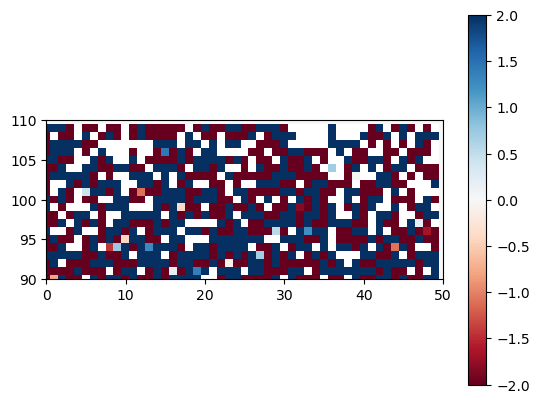

In [163]:
arr = dx.copy()
mask = ((arr < 100) & (arr > -100))
arr[~mask] = np.nan
plt.imshow(arr,cmap='RdBu',vmin=-2,vmax=2)
plt.colorbar()
plt.ylim(int(9000/window),int(11000/window))
plt.xlim(int(0/window),int(5000/window))

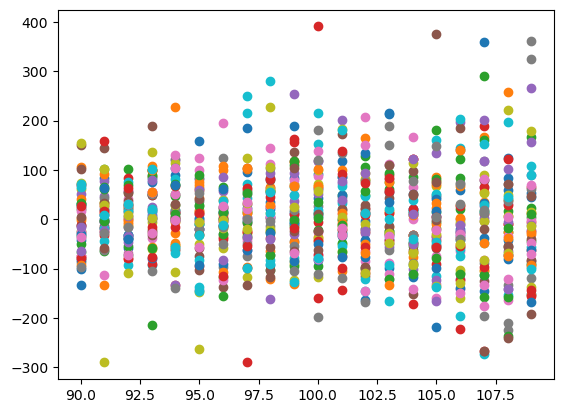

In [165]:
for i in range(0,50):
    plt.scatter(np.arange(90,110),dx[90:110,i])

In [21]:
threshold = 0.02
trans_init = np.eye(4)

In [19]:
pts = np.float64(np.column_stack([pos[0].flatten(),pos[1].flatten(),postd.flatten()]))
source = o3d.geometry.PointCloud()
source.points = o3d.utility.Vector3dVector(pts)
pts = np.float64(np.column_stack([pos[0].flatten(),pos[1].flatten(),pred.flatten()]))
target = o3d.geometry.PointCloud()
target.points = o3d.utility.Vector3dVector(pts)

In [36]:
reg_p2p.transformation[0,-1]

np.float64(0.012403244484345644)

In [22]:
print("Apply point-to-point ICP")
reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint())
print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)
draw_registration_result(source, target, reg_p2p.transformation)

Apply point-to-point ICP
RegistrationResult with fitness=3.950000e-02, inlier_rmse=1.160123e-02, and correspondence_set size of 9875
Access transformation to get result.
Transformation is:
[[ 1.00000000e+00  1.21093481e-06 -1.51221662e-05  1.24032445e-02]
 [-1.21043275e-06  9.99999999e-01  3.31997095e-05 -2.90545894e-02]
 [ 1.51222064e-05 -3.31996912e-05  9.99999999e-01  3.44350608e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [20]:
source

PointCloud with 198835 points.

In [2]:
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp],
                                      zoom=0.4459,
                                      front=[0.9288, -0.2951, -0.2242],
                                      lookat=[1.6784, 2.0612, 1.4451],
                                      up=[-0.3402, -0.9189, -0.1996])

In [17]:
demo_icp_pcds = o3d.data.DemoICPPointClouds()
source = o3d.io.read_point_cloud(demo_icp_pcds.paths[0])
target = o3d.io.read_point_cloud(demo_icp_pcds.paths[1])
threshold = 0.02
trans_init = np.asarray([[0.862, 0.011, -0.507, 0.5],
                         [-0.139, 0.967, -0.215, 0.7],
                         [0.487, 0.255, 0.835, -1.4], [0.0, 0.0, 0.0, 1.0]])
draw_registration_result(source, target, trans_init)

In [18]:
source

PointCloud with 198835 points.

In [5]:
reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint(),
    o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=2000))
print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)
draw_registration_result(source, target, reg_p2p.transformation)

RegistrationResult with fitness=6.211230e-01, inlier_rmse=6.583448e-03, and correspondence_set size of 123501
Access transformation to get result.
Transformation is:
[[ 0.84024592  0.00687676 -0.54241281  0.6463702 ]
 [-0.14819104  0.96517833 -0.21706206  0.81180074]
 [ 0.52111439  0.26195134  0.81189372 -1.48346821]
 [ 0.          0.          0.          1.        ]]
